<div style="text-align: right;">
    <img src="logo.webp" alt="Logo" width="200"/>
</div>
<p style="font-size: 50px; text-align: center;">Multiple Testing</p>


### Purpose

The notebook seems to be focused on illustrating various concepts related to statistical hypothesis testing and multiple testing correction using Python. It starts by generating synthetic data, performing t-tests, and demonstrating concepts like family-wise error rate, Bonferroni correction, Holm's correction, Benjamini-Hochberg correction, and a re-sampling approach for hypothesis testing.

### Preconditions and Dependencies: 

The code assumes that you have imported necessary libraries like numpy, pandas, matplotlib, statsmodels, and scipy.stats. Additionally, there is a reference to ISLP which could be a custom module or external data source for loading data.

### Dataset Used: 

The code generates synthetic data (X) and also uses a dataset named "[Fund](https://islp.readthedocs.io/en/latest/datasets/Fund.html)" and "[Khan](https://islp.readthedocs.io/en/latest/datasets/Khan.html)". "Fund" dataset is used for various hypothesis testing scenarios, and "Khan" dataset is used for a re-sampling approach in hypothesis testing.

### Explanation of Code:

1. It starts by generating synthetic data and calculating p-values from t-tests on each column of the data (X).
2. It categorizes the results of the t-tests into 'Reject H0' or 'Do not reject H0' based on a significance level of 0.05.
3. It demonstrates the family-wise error rate using visualizations.
4. It performs t-tests, Bonferroni correction, Holm's correction, and Benjamini-Hochberg correction on a subset of the "Fund" dataset.
5. It calculates and displays the mean of the "fund_mini" dataset.
6. It performs a paired t-test between two columns of the "fund_mini" dataset.
7. It calculates q-values and analyzes the results using Benjamini-Hochberg correction.
8. It conducts a re-sampling approach for hypothesis testing between two subsets of the "Khan" dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from ISLP import load_data

In [2]:
from scipy.stats import (ttest_1samp , ttest_rel , ttest_ind , t as t_dbn)
from statsmodels.stats.multitest import multipletests as mult_test

- **ttest_1samp :** Perform one-sample t-test
- **ttest_rel :** Perform two-sample t-test, comparing means of two related samples
- **ttest_ind :** Perform two-sample t-test, comparing means of two independent samples
- **t_dbn :** t-distribution

Performing some one-sample t-tests by creating 100 variables, each consisting of 10 observations. 
The first 50 variables have mean 0.5 and variance 1, while the others have mean 0 and variance 1.

In [3]:
rng = np.random.default_rng(12)

X = rng.standard_normal((10, 100)) 

true_mean = np.array([0.5]*50 + [0]*50) 
X += true_mean[None,:]

In [4]:
result = ttest_1samp(X[:,0], 0)
result.pvalue

0.9307442156164141

In [5]:
p_values = np.empty(100) 

for i in range(100):
    p_values[i] = ttest_1samp(X[:,i], 0).pvalue 
    
decision = pd.cut(p_values, [0, 0.05, 1], labels=['Reject H0','Do not reject H0']) 
truth = pd.Categorical(true_mean == 0, categories=[True, False], ordered=True)

In [6]:
pd.crosstab(decision, truth , rownames=['Decision'], colnames=['H0'])

H0,True,False
Decision,,
Reject H0,5,15
Do not reject H0,45,35


<div style="background-color: #FFD700; color: black; padding: 10px; font-size: 20px; text-align: center;">
    Family-Wise Error Rate
</div>

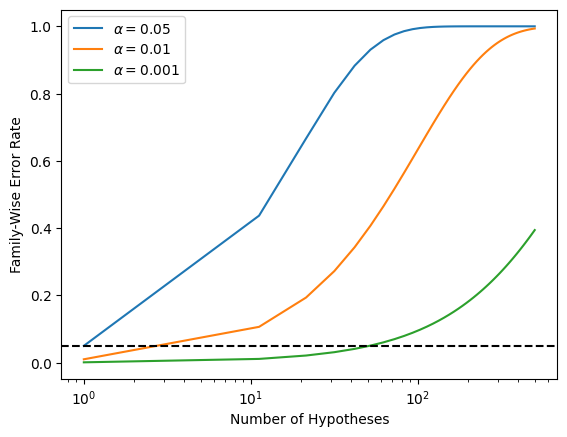

In [7]:
m = np.linspace(1, 501) 
fig, ax = plt.subplots() 
[ax.plot(m, 1 - (1 - alpha)**m, label=r'$\alpha=%s$' % str(alpha)) for alpha in [0.05, 0.01, 0.001]]

ax.set_xscale('log') 
ax.set_xlabel('Number of Hypotheses') 
ax.set_ylabel('Family-Wise Error Rate') 
ax.legend()
ax.axhline(0.05, c='k', ls='--');

In [8]:
Fund = load_data('Fund') 
fund_mini = Fund.iloc[:,:5] 
fund_mini_pvals = np.empty(5) 
for i in range (5):
    fund_mini_pvals[i] = ttest_1samp(fund_mini.iloc[:,i], 0).pvalue 
fund_mini_pvals

array([0.00620236, 0.91827115, 0.01160098, 0.6005396 , 0.75578151])

<div style="background-color: #FFD700; color: black; padding: 10px; font-size: 20px; text-align: center;">
    Bonferroni Correction Method
</div>

In [9]:
reject, bonf_pvalues = mult_test(fund_mini_pvals, method = "bonferroni", alpha=0.05)[:2] 
reject

array([ True, False, False, False, False])

<div style="background-color: #FFD700; color: black; padding: 10px; font-size: 20px; text-align: center;">
    Holm's Correction Method
</div>

In [10]:
reject, holm_pvalues = mult_test(fund_mini_pvals, method = "holm", alpha=0.05)[:2]
reject

array([ True, False,  True, False, False])

In [11]:
print(fund_mini.mean())

ttest_rel(fund_mini['Manager1'],fund_mini['Manager2']).pvalue

Manager1    3.0
Manager2   -0.1
Manager3    2.8
Manager4    0.5
Manager5    0.3
dtype: float64


0.038391072368079586

<div style="background-color: #FFD700; color: black; padding: 10px; font-size: 20px; text-align: center;">
    Benjamini-Hochberg Correction Method
</div>

In [12]:
fund_pvalues = np.empty(2000)
for i, manager in enumerate(Fund.columns):
    fund_pvalues[i] = ttest_1samp(Fund[manager], 0).pvalue

In [13]:
fund_qvalues = mult_test(fund_pvalues , method = "fdr_bh")[1] 
fund_qvalues [:10]

array([0.08988921, 0.991491  , 0.12211561, 0.92342997, 0.95603587,
       0.07513802, 0.0767015 , 0.07513802, 0.07513802, 0.07513802])

In [14]:
(fund_qvalues <= 0.1).sum()

146

In [15]:
(fund_pvalues <= 0.1 / 2000).sum()

0

In [16]:
sorted_ = np.sort(fund_pvalues) 
m = fund_pvalues.shape[0]
q = 0.1
sorted_set_ = np.where(sorted_ < q * np.linspace(1, m, m) / m)[0] 
if sorted_set_.shape[0] > 0:
    selected_ = fund_pvalues < sorted_[sorted_set_].max()
    sorted_set_ = np.arange(sorted_set_.max()) 
else:
    selected_ = [] 
    sorted_set_ = []

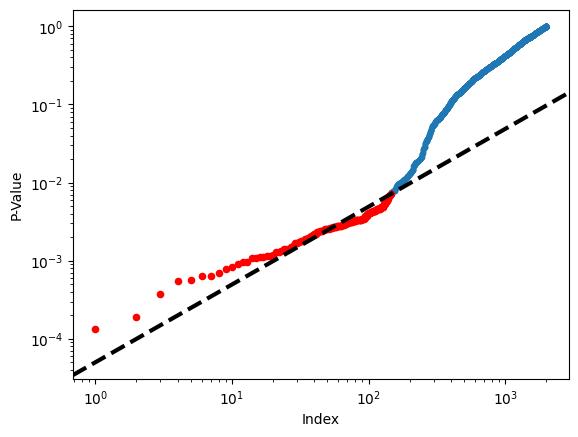

In [17]:
fig, ax = plt.subplots()
ax.scatter(np.arange(0, sorted_.shape[0]) + 1, sorted_, s=10)
ax.set_yscale('log')
ax.set_xscale('log') 
ax.set_ylabel('P-Value') 
ax.set_xlabel('Index')
ax.scatter(sorted_set_+1, sorted_[sorted_set_], c='r', s=20) 
ax.axline((0, 0), (1,q/m), c='k', ls='--', linewidth=3);

<div style="background-color: #FFD700; color: black; padding: 10px; font-size: 20px; text-align: center;">
    A Re-Sampling Approach
</div>

In [18]:
Khan = load_data('Khan')
D = pd.concat([Khan['xtrain'], Khan['xtest']])
D['Y'] = pd.concat([Khan['ytrain'], Khan['ytest']]) 
D['Y'].value_counts()

Y
2    29
4    25
3    18
1    11
Name: count, dtype: int64

In [19]:
D2 = D[lambda df:df['Y'] == 2]
D4 = D[lambda df:df['Y'] == 4]
gene_11 = 'G0011'
observedT, pvalue = ttest_ind(D2[gene_11], D4[gene_11], equal_var=True)
observedT, pvalue

(-2.0936330736768185, 0.04118643782678394)

In [20]:
B = 10000
Tnull = np.empty(B)

D_ = np.hstack([D2[gene_11], D4[gene_11]]) 
n_ = D2[gene_11].shape[0]
D_null = D_.copy()

for b in range(B):
    rng.shuffle(D_null)
    ttest_ = ttest_ind(D_null[:n_], D_null[n_:], equal_var=True)
    Tnull[b] = ttest_.statistic 
    
(np.abs(Tnull) > np.abs(observedT)).mean()

0.0404

- Without shuffling data,  pvalue = 0.0411
- with re-shuffling data, pvalue = 0.0393

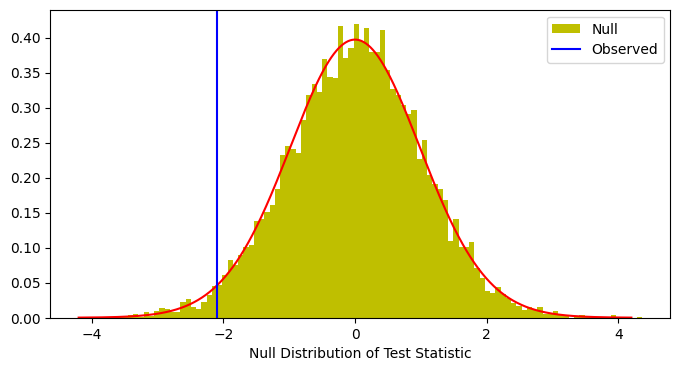

In [21]:
fig, ax = plt.subplots(figsize=(8,4)) 
ax.hist(Tnull, bins=100, density=True, facecolor='y', label='Null')
xval = np.linspace(-4.2, 4.2, 1001)
ax.plot(xval, t_dbn.pdf(xval, D_.shape[0]-2), c='r') 
ax.axvline(observedT, c='b', label='Observed') 
ax.legend()
ax.set_xlabel("Null Distribution of Test Statistic");